<a href="https://colab.research.google.com/github/gowthambalachandhiran/VisualQuestionAnswering/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Welcome to Colaboratory!</h1>


Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

In [0]:
#@title Introducing Colaboratory { display-mode: "form" }
#@markdown This 3-minute video gives an overview of the key features of Colaboratory:
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI', width=600, height=400)

## Getting Started

The document you are reading is a  [Jupyter notebook](https://jupyter.org/), hosted in Colaboratory. It is not a static page, but an interactive environment that lets you write and execute code in Python and other languages.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [0]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter".

All cells modify the same global state, so variables that you define by executing a cell can be used in other cells:

In [0]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

For more information about working with Colaboratory notebooks, see [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb).


## More Resources

Learn how to make the most of Python, Jupyter, Colaboratory, and related tools with these resources:

### Working with Notebooks in Colaboratory
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb)
- [Tensorflow concepts](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [First steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Intro to neural nets](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [Intro to sparse data and embeddings](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

## Machine Learning Examples: Seedbank

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out the [Seedbank](https://research.google.com/seedbank/) project.

A few featured examples:

- [Neural Style Transfer](https://research.google.com/seedbank/seed/neural_style_transfer_with_tfkeras): Use deep learning to transfer style between images.
- [EZ NSynth](https://research.google.com/seedbank/seed/ez_nsynth): Synthesize audio with WaveNet auto-encoders.
- [Fashion MNIST with Keras and TPUs](https://research.google.com/seedbank/seed/fashion_mnist_with_keras_and_tpus): Classify fashion-related images with deep learning.
- [DeepDream](https://research.google.com/seedbank/seed/deepdream): Produce DeepDream images from your own photos.
- [Convolutional VAE](https://research.google.com/seedbank/seed/convolutional_vae): Create a generative model of handwritten digits.

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os, argparse
import cv2, spacy, numpy as np
import keras
from keras.layers import Input, LSTM, Embedding, Dense
from keras.applications.vgg16 import VGG16 
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
import csv

In [0]:
def get_image_model_without():
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    image_model = VGG_16()
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [3]:
model = VGG16(weights="imagenet", include_top=False)
model.summary()











58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
____________________________________________________

In [0]:
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in dataset:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return features

In [0]:
import os

In [0]:
path = '/bin/Xray'

In [0]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

In [8]:
print(files)

['/bin/Xray/39.jpg', '/bin/Xray/9.jpg', '/bin/Xray/56.jpg', '/bin/Xray/5.jpg', '/bin/Xray/23.jpg', '/bin/Xray/15.jpg', '/bin/Xray/8.jpg', '/bin/Xray/29.jpg', '/bin/Xray/13.jpg', '/bin/Xray/28.jpg', '/bin/Xray/35.jpg', '/bin/Xray/10.jpg', '/bin/Xray/3.jpg', '/bin/Xray/33.jpg', '/bin/Xray/20.jpg', '/bin/Xray/4.jpg', '/bin/Xray/53.jpg', '/bin/Xray/37.jpg', '/bin/Xray/58.jpg', '/bin/Xray/36.jpg', '/bin/Xray/2.jpg', '/bin/Xray/43.jpg', '/bin/Xray/7.jpg', '/bin/Xray/17.jpg', '/bin/Xray/42.jpg', '/bin/Xray/24.jpg', '/bin/Xray/46.jpg', '/bin/Xray/32.jpg', '/bin/Xray/54.jpg', '/bin/Xray/41.jpg', '/bin/Xray/6.jpg', '/bin/Xray/18.jpg', '/bin/Xray/19.jpg', '/bin/Xray/34.jpg', '/bin/Xray/16.jpg', '/bin/Xray/21.jpg', '/bin/Xray/25.jpg', '/bin/Xray/47.jpg', '/bin/Xray/40.jpg', '/bin/Xray/55.jpg', '/bin/Xray/31.jpg', '/bin/Xray/26.jpg', '/bin/Xray/22.jpg', '/bin/Xray/12.jpg', '/bin/Xray/38.jpg', '/bin/Xray/27.jpg', '/bin/Xray/50.jpg', '/bin/Xray/49.jpg', '/bin/Xray/11.jpg', '/bin/Xray/1.jpg', '/bin/Xr

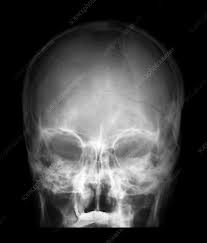

In [9]:
#sample image
from IPython.display import Image
Image(filename='/bin/Xray/9.jpg') 

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.applications import imagenet_utils

In [0]:
train_features = create_features(files, model)

In [16]:
#features from sample image
train_features[8]

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  6.0280094 , 25.553444  , ..., 11.59653   ,
          0.        ,  0.        ],
        [ 0.        , 11.253768  , 19.656885  , ...,  6.1125584 ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.18008399,  0.        , ...,  0.        ,
          3.9985805 ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 6.266992  , 18.66488   ,  0.        , ...,  

In [19]:
train_features.shape

(56, 512, 7, 7)

In [0]:
def get_question_features_without_fd(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 96))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [0]:
csv_path = '/Xray/CSV'

In [0]:
import pandas as pd

In [0]:
training_csv = pd.read_csv('/bin/Xray/CSV/training.csv')

In [35]:
training_csv.head(5)

,Imageid,Question,Answer
0,1,is this xray,yes
1,2,Does this image has single or multiple facture,single
2,3,Does this image have single or multiple facture,multiple
3,4,is this xray showing foreign body,foreign
4,5,is this xray,yes


In [0]:
questions=training_csv['Question'].tolist()

In [27]:
#sample questions for training
questions[0]

'is this xray'

In [0]:
trainX= []
questions_tensor = []
for question in questions:
  question_features = get_question_features_without_fd(question)
  questions_tensor.append(question_features)

In [36]:
len(questions_tensor)

56

In [37]:
len(train_features)

56

In [0]:
for image,questions in zip(train_features,questions_tensor):
  trainX.append([image,questions])

In [39]:
np.array(trainX).shape

(56, 2)

In [0]:
question_features_array = []
image_features_array = []
for x in trainX:
  question_features_array.append(x[0])
  image_features_array.append(x[1])

In [41]:
question_features_array[0]

array([[[ 0.       , 21.212252 ,  0.       , ...,  0.       ,
         18.89872  ,  0.       ],
        [ 0.       ,  6.5687494,  0.       , ...,  0.7074292,
          6.3412294,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 1.0684202,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  5.546841 , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.

In [42]:
question_features_array = np.array(question_features_array)
image_features_array = np.array(image_features_array)
print(question_features_array.shape)
print(image_features_array.shape)

(56, 512, 7, 7)
(56, 30, 96)


In [0]:
trainY = training_csv['Answer'].tolist()

In [44]:
trainY[0]

'yes'

In [45]:
set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[8, 9, 7, 2, 8, 2, 6, 0, 0, 0, 0, 6, 4, 4, 5, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8]


In [0]:
trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=10)

In [59]:

word_embeddings = spacy.load('en')
obama = word_embeddings(u"obama")
putin = word_embeddings(u"putin")
banana = word_embeddings(u"banana")
monkey = word_embeddings(u"monkey")
obama.similarity(putin)


0.4547074384807158

In [60]:
question_features_array.shape

(56, 512, 7, 7)

In [61]:
image_features_array.shape

(56, 30, 96)

TypeError: ignored

In [51]:
our_vqa_model.fit([question_features_array,image_features_array],trainY_cate,5,10)

NameError: ignored